# Mandelbrot Set - Mini Project - Stage 2

Numerical Scientific Computing (CE8-AVS) - Spring 2023 - Mini Project

**Author:** [Máté Tallósi](https://github.com/tallosim)
**Date:** 2023-03-22

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import multiprocessing as mp
from numba import jit
import time
from tqdm import tqdm

## Parameter Definition

The following parameters are used to define the Mandelbrot set. The parameters are defined in the following cell.

The resolution of the image is defined by the `X_RES` and `Y_RES` parameters. The `X_MIN`, `X_MAX`, `Y_MIN`, and `Y_MAX` parameters define the area of the complex plane that is displayed. The `I` parameter defines the maximum number of iterations for each pixel. The `T` parameter defines the threshold value for the Mandelbrot set.

In [2]:
X_RES = 5000
X_MIN = -2
X_MAX = 0.5
Y_RES = 5000
Y_MIN = -1.25
Y_MAX = 1.25

I = 50
T = 2

np.seterr(all='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

### Madelbrot Set Ploting

In [3]:
def make_plot(M, cmap='hot', save=False, filename='mandelbrot.png'):
    plt.figure(figsize=(16, 16))
    plt.imshow(M, cmap=cmap, aspect='equal', extent=[X_MIN, X_MAX, Y_MIN, Y_MAX])

    if save:
        plt.savefig(filename, dpi=600, bbox_inches='tight', pad_inches=0)

## Datatype Optimization

### Naive (loops) Implementation

In [4]:
def mandelbrot_naive(re, im, M, I, T):
    if (im.shape[0], re.shape[0]) != M.shape:
        raise ValueError('C and M must have the same shape')
    
    x_max, y_max = M.shape
    
    for x in range(x_max):
        for y in range(y_max):
            z = 0 + 0j
            for i in range(I):
                z = z**2 + re[y] + im[x] * 1j
                if T <= abs(z):
                    M[x, y] = i / I
                    break
            else:
                M[x, y] = 1

### Numpy (vectorized) Implementation

In [5]:
def mandelbrot_vectorized(re, im, M, I, T):
    if (im.shape[0], re.shape[0]) != M.shape:
        raise ValueError('C and M must have the same shape')
    
    c = re + im[:, np.newaxis] * 1j
    z = np.zeros_like(c)

    for i in range(I):
        z = z**2 + c
        M[T <= abs(z)] = i / I
        
    M[M == 0] = 1

### Numba (optimized) Implementation

In [6]:
@jit(nopython=True)
def mandelbrot_numba(re, im, M, I, T):
    if (im.shape[0], re.shape[0]) != M.shape:
        raise ValueError('C and M must have the same shape')
    
    x_max, y_max = M.shape
    
    for x in range(x_max):
        for y in range(y_max):
            z = 0 + 0j
            for i in range(I):
                z = z**2 + re[y] + im[x] * 1j
                if T <= abs(z):
                    M[x, y] = i / I
                    break
            else:
                M[x, y] = 1

### Parallel (using multiprocessing) Implementation

In [7]:
@jit(nopython=True)
def mandelbrot_chunk(re, im, I, T):
    M = np.zeros((im.shape[0], re.shape[0]))
    
    x_max, y_max = M.shape
    
    for x in range(x_max):
        for y in range(y_max):
            z = 0 + 0j
            for i in range(I):
                z = z**2 + re[y] + im[x] * 1j
                if abs(z) > T:
                    M[x, y] = i
                    break
            else:
                M[x, y] = I
    
    return M

def mandelbrot_paralell(re, im, I, T, P=8, C=20):
    pool = mp.Pool(processes=P)

    results = [pool.apply_async(mandelbrot_chunk, args=(re[i:i+C], im, I, T)) for i in range(0, re.shape[0], C)]

    pool.close()
    pool.join()

    return results

### Default datatypes

In [8]:
re = np.linspace(X_MIN, X_MAX, X_RES)
im = np.linspace(Y_MIN, Y_MAX, Y_RES)

print(f'Default data type of `re` and `im`: {re.dtype}, {im.dtype}')

Default data type of `re` and `im`: float64, float64


### Running time comparison

In [9]:
float_datatypes = [float, np.float16, np.float32, np.float64]
implementations = [mandelbrot_naive, mandelbrot_vectorized, mandelbrot_numba, mandelbrot_paralell]

results = list()

for float_datatype in float_datatypes:
    for implementation in implementations:
        # Skip numba and paralell implementation with float16
        # because numba does not support float16
        if float_datatype.__name__ == 'float16':
            if implementation.__name__ == 'mandelbrot_numba' or \
                implementation.__name__ == 'mandelbrot_paralell':
                results.append((implementation.__name__, float_datatype.__name__, np.nan))
                continue
        
        M = np.zeros((X_RES, Y_RES))
        
        re = np.linspace(X_MIN, X_MAX, X_RES, dtype=float_datatype)
        im = np.linspace(Y_MIN, Y_MAX, Y_RES, dtype=float_datatype)
        
        time_start = time.time()
        implementation(re, im, M, I, T)
        time_delta = time.time() - time_start
        
        results.append((implementation.__name__, float_datatype.__name__, time_delta))
        
results = pd.DataFrame(results, columns=['Implementation', 'Float Datatype', 'Time'])
results.to_csv(f'madelbrot-datatypes-{X_RES}x{Y_RES}-results.csv', index=False)
results

,Implementation,Float Datatype,Time
0,mandelbrot_naive,float,901.334065
1,mandelbrot_vectorized,float,14.536290
2,mandelbrot_numba,float,3.400419
3,mandelbrot_paralell,float,120.777780
4,mandelbrot_naive,float16,981.477006
5,mandelbrot_vectorized,float16,9.424147
6,mandelbrot_numba,float16,NaN
7,mandelbrot_paralell,float16,NaN
8,mandelbrot_naive,float32,934.799615
9,mandelbrot_vectorized,float32,9.615335


<Figure size 4800x4800 with 0 Axes>

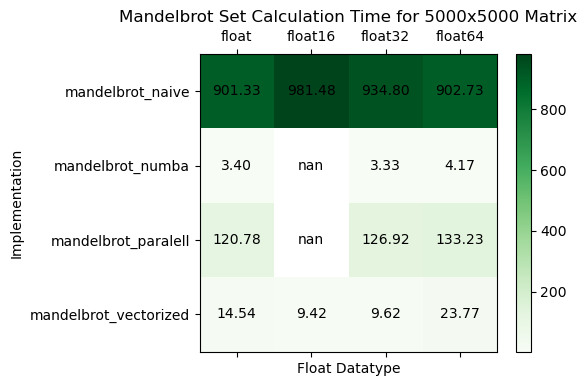

In [10]:
matrix = results.pivot(index='Implementation', columns='Float Datatype', values='Time')

fig = plt.figure(figsize=(16, 16), facecolor='w', edgecolor='k', dpi=300)

plt.matshow(matrix, cmap='Greens')
plt.xticks(range(len(matrix.columns)), matrix.columns)
plt.yticks(range(len(matrix.index)), matrix.index)
plt.xlabel('Float Datatype')
plt.ylabel('Implementation')
plt.colorbar(shrink=0.8, pad=0.05)
plt.title(f'Mandelbrot Set Calculation Time for {X_RES}x{Y_RES} Matrix')

for (i, j), z in np.ndenumerate(matrix):
    plt.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')

plt.show()

## Dask (distributed) Implementation of the Mandelbrot Set